In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-15 17:12:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-08-15 17:12:06 (7.39 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’ saved [178509/178509]



In [2]:
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
df.head()


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
## The seasonality of our data is weak (data collected per time)
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [4]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

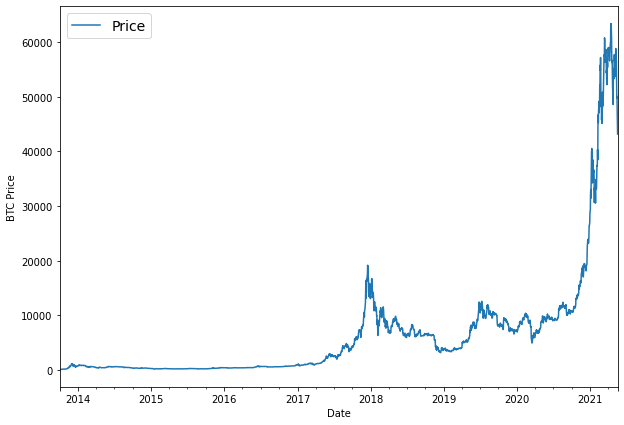

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend(fontsize=14);


In [6]:
## Split
split_size = int(0.8 * len(prices)) # 80% train, 20% test


X_train, y_train = timesteps[:split_size], prices[:split_size]


X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [7]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

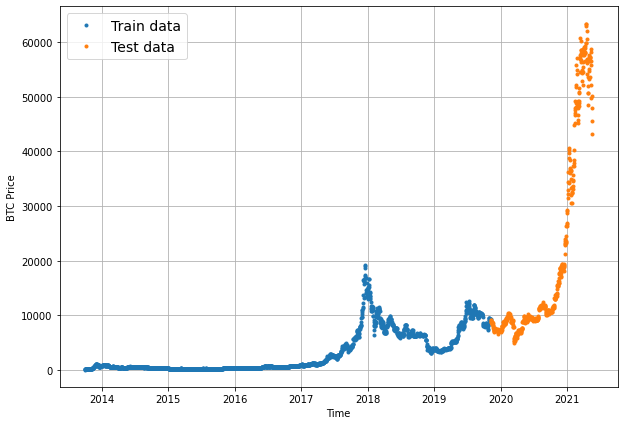

In [8]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [9]:
import tensorflow as tf
import numpy as np
from keras import layers

In [10]:
# A function to evaluate our model
def mean_absolute_scaled_error(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) 

  return mae / mae_naive_no_season

# def evaluate_preds(y_true, y_pred):

#   y_true = tf.cast(y_true, dtype=tf.float32)
#   y_pred = tf.cast(y_pred, dtype=tf.float32)

#   mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
#   mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
#   rmse = tf.sqrt(mse)
#   mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
#   mase = mean_absolute_scaled_error(y_true, y_pred)
  
#   return {"mae": mae.numpy(),
#           "mse": mse.numpy(),
#           "rmse": rmse.numpy(),
#           "mape": mape.numpy(),
#           "mase": mase.numpy()}

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [11]:
# ## Windowing our data, Note that everytime you change the horizon and window size, u need to make the windows and training/test splits again
HORIZON = 1 #steps to be predicted
WINDOW_SIZE = 7 # 7 days used to predict this 1 step (horizon)

def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:] #input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])

#test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

In [12]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [13]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [14]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [15]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

## In this case, window is 7 and horizon is 1, so this is a many to one RNN problem, if horizon>1, then it would have been a many to many problem


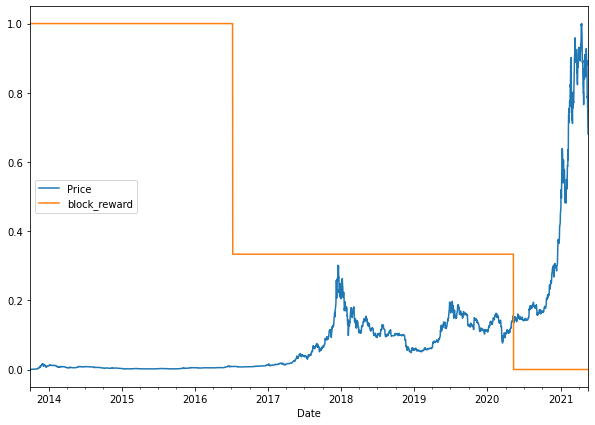

In [16]:
## IF we want to add another variable to make it univariate
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()
## PLOT
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [19]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [20]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [21]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [22]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

In [28]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7

In [30]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [23]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [31]:
# Same hyperparameters as the ones used in the paper
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [35]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

In [ ]:
%%time


tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mse"],
                # experimental_run_tf_function=False
                )

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            # callbacks=[
            #           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)]
            )